# Business understanding
The goal of this project is to build a model that indentifies a phishing website based on its features. Furthermore, we want to test if a decision tree or a random forest performs better. Expected outcome is to have a working model with over 90% accuracy. 

## Data preparation
The data we use is the Phishing website dataset from the UCI Machine learning repository.

### Target variable
Result:
- 1 means phishing website
- -1 means legit webiste

### Data splitting
- 75% for training the model
- 25% for testing the model

Fetch dataset and imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
phishing_websites = fetch_ucirepo(id=327) 
  
# data (as pandas dataframes) 
X = phishing_websites.data.features

y = phishing_websites.data.targets 
df = pd.concat([X, y], axis=1)
X.head()



,having_ip_address,url_length,shortining_service,having_at_symbol,double_slash_redirecting,prefix_suffix,having_sub_domain,sslfinal_state,domain_registration_length,favicon,...,rightclick,popupwindow,iframe,age_of_domain,dnsrecord,web_traffic,page_rank,google_index,links_pointing_to_page,statistical_report
0,-1,1,1,1,-1,-1,-1,-1,-1,1,...,1,1,1,-1,-1,-1,-1,1,1,-1
1,1,1,1,1,1,-1,0,1,-1,1,...,1,1,1,-1,-1,0,-1,1,1,1
2,1,0,1,1,1,-1,-1,-1,-1,1,...,1,1,1,1,-1,1,-1,1,0,-1
3,1,0,1,1,1,-1,-1,-1,1,1,...,1,1,1,-1,-1,1,-1,1,-1,1
4,1,0,-1,1,1,-1,1,1,-1,1,...,1,-1,1,-1,-1,0,-1,1,1,1


Split the dataset to training and testing sets

In [2]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=20)

## Modeling
### **Decision Tree Model**  
- **Algorithm:** `DecisionTreeClassifier`  
- **Pruning Strategy:** Cost-Complexity Pruning (`ccp_alpha`)  
   - The optimal `ccp_alpha` was selected based on cross-validation performance to balance model complexity and accuracy.  
- **Hyperparameter Tuning:**  
   - Evaluated multiple `ccp_alpha` values to identify the best-performing model.  

### **Evaluation Metrics**  
- **Accuracy:** Measures overall correctness of the model.  
- **Precision:** Assesses how many predicted positives are actual positives.  
- **Recall:** Evaluates the model's ability to identify all relevant cases.  
- **F1-Score:** Harmonic mean of precision and recall for balanced performance evaluation.  
- **Cross-Validation:** Used to ensure model stability across different data splits.

In [3]:
model = DecisionTreeClassifier(random_state=0)

# Returns the effective alphas and the corresponding total leaf impurities at each step of the pruning process.
path = model.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

threshold = 0.01 
mask = ccp_alphas < threshold


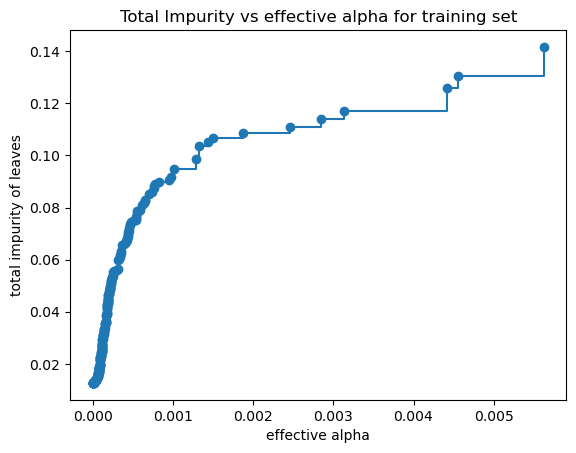

In [4]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[mask], impurities[mask], marker="o", drawstyle="steps-post")
ax.set_xlabel("Effective alpha")
ax.set_ylabel("Total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set");

In [5]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)

Number of nodes in the last tree is: 1 with ccp_alpha: 0.2958412167152224


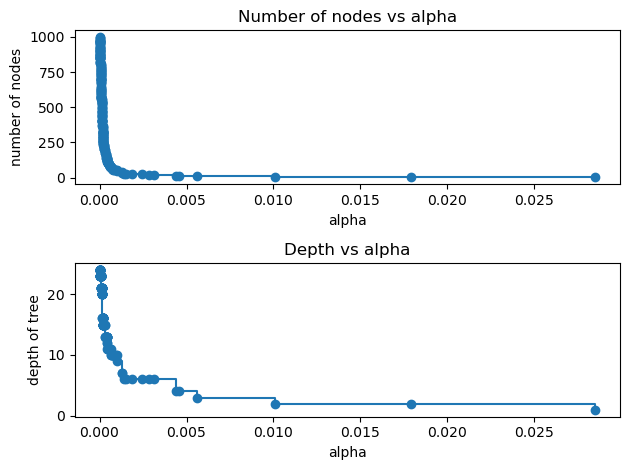

In [6]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("Alpha")
ax[0].set_ylabel("Number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("Alpha")
ax[1].set_ylabel("Depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

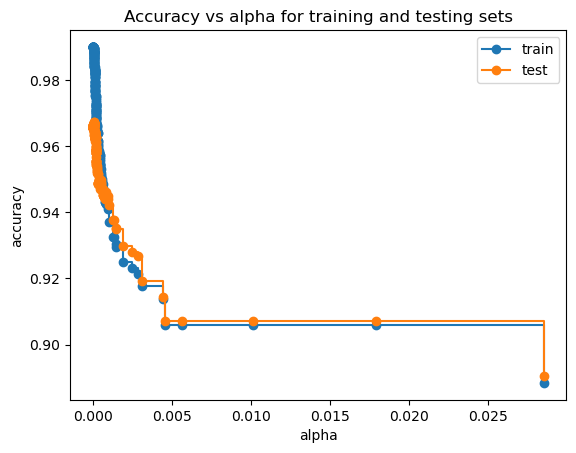

In [7]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("Alpha")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

# **Instructions for Identifying Potential Phishing Websites**

These instructions guide an internet analyst through a structured process to determine if a website is likely a phishing site, following the logic of the decision tree.

---

## **Step 1: Check SSL Certificate Status**
- **Action:** Verify if the website uses HTTPS with a valid SSL certificate.
  - **How:** Look for `https://` in the URL and a padlock icon in the browser address bar.
- **Decision:**
  - If **SSL is not valid or missing**, proceed to **Step 2**.
  - If **SSL is valid**, proceed to **Step 3**.

---

## **Step 2: Analyze Anchored URLs**
- **Action:** Review the links (anchors) on the page.
  - **How:** Check if many links point to suspicious or unrelated domains.
- **Decision:**
  - If **high number of suspicious links**, proceed to **Step 2.1**.
  - If **few or no suspicious links**, the site is likely **Legitimate**.

### **Step 2.1: Check Links in Meta, Script, and Link Tags**
- **Action:** Inspect the website’s source code.
  - **How:** Look for external links in `<meta>`, `<script>`, and `<link>` tags.
- **Decision:**
  - If **few suspicious links**, proceed to **Step 2.1.1**.
  - If **many suspicious links**, proceed to **Step 2.1.2**.

#### **Step 2.1.1: Check for Prefix-Suffix in Domain**
- **Action:** Look for hyphens in the domain (e.g., `secure-login.com`).
- **Decision:**
  - If **no suspicious prefix/suffix**, the site is likely **Legitimate**.
  - If **suspicious prefix/suffix**, the site is likely **Phishing**.


#### **Step 2.1.2: Check Domain Registration Length**
- **Action:** Verify how long the domain has been registered.
  - **How:** Use WHOIS lookup services.
- **Decision:**
  - If **long registration**, the site is likely **Legitimate**.
  - If **short registration**, the site is likely **Phishing**.


---

## **Step 3: Analyze Anchored URLs**
- **Action:** Evaluate the presence of suspicious anchors.
- **Decision:**
  - If **few suspicious anchors**, proceed to **Step 3.1**.
  - If **many suspicious anchors**, proceed to **Step 3.2**.

### **Step 3.1: Check for Prefix-Suffix in Domain**
- **Action:** Look for hyphens in the domain.
- **Decision:**
  - If **no suspicious prefix/suffix**, the site is likely **Legitimate**.
  - If **suspicious prefix/suffix**, the site is likely **Phishing**.

### **Step 3.2: Review Website Traffic**
- **Action:** Evaluate the website's popularity.
  - **How:** Use tools like Alexa or SimilarWeb.
- **Decision:**
  - If **low traffic**, the site is likely **Phishing**.
  - If **high traffic**, proceed to **Step 3.2.1**.



#### **Step 3.2.1: Check for Subdomains**
- **Action:** Identify if the website uses excessive subdomains.
- **Decision:**
  - If **no excessive subdomains**, the site is likely **Phishing**.
  - If **excessive subdomains**, the site is likely **Legitimate**.

---

## **Final Notes:**
- Always cross-check suspicious findings with other indicators.
- Report borderline cases for further technical review.


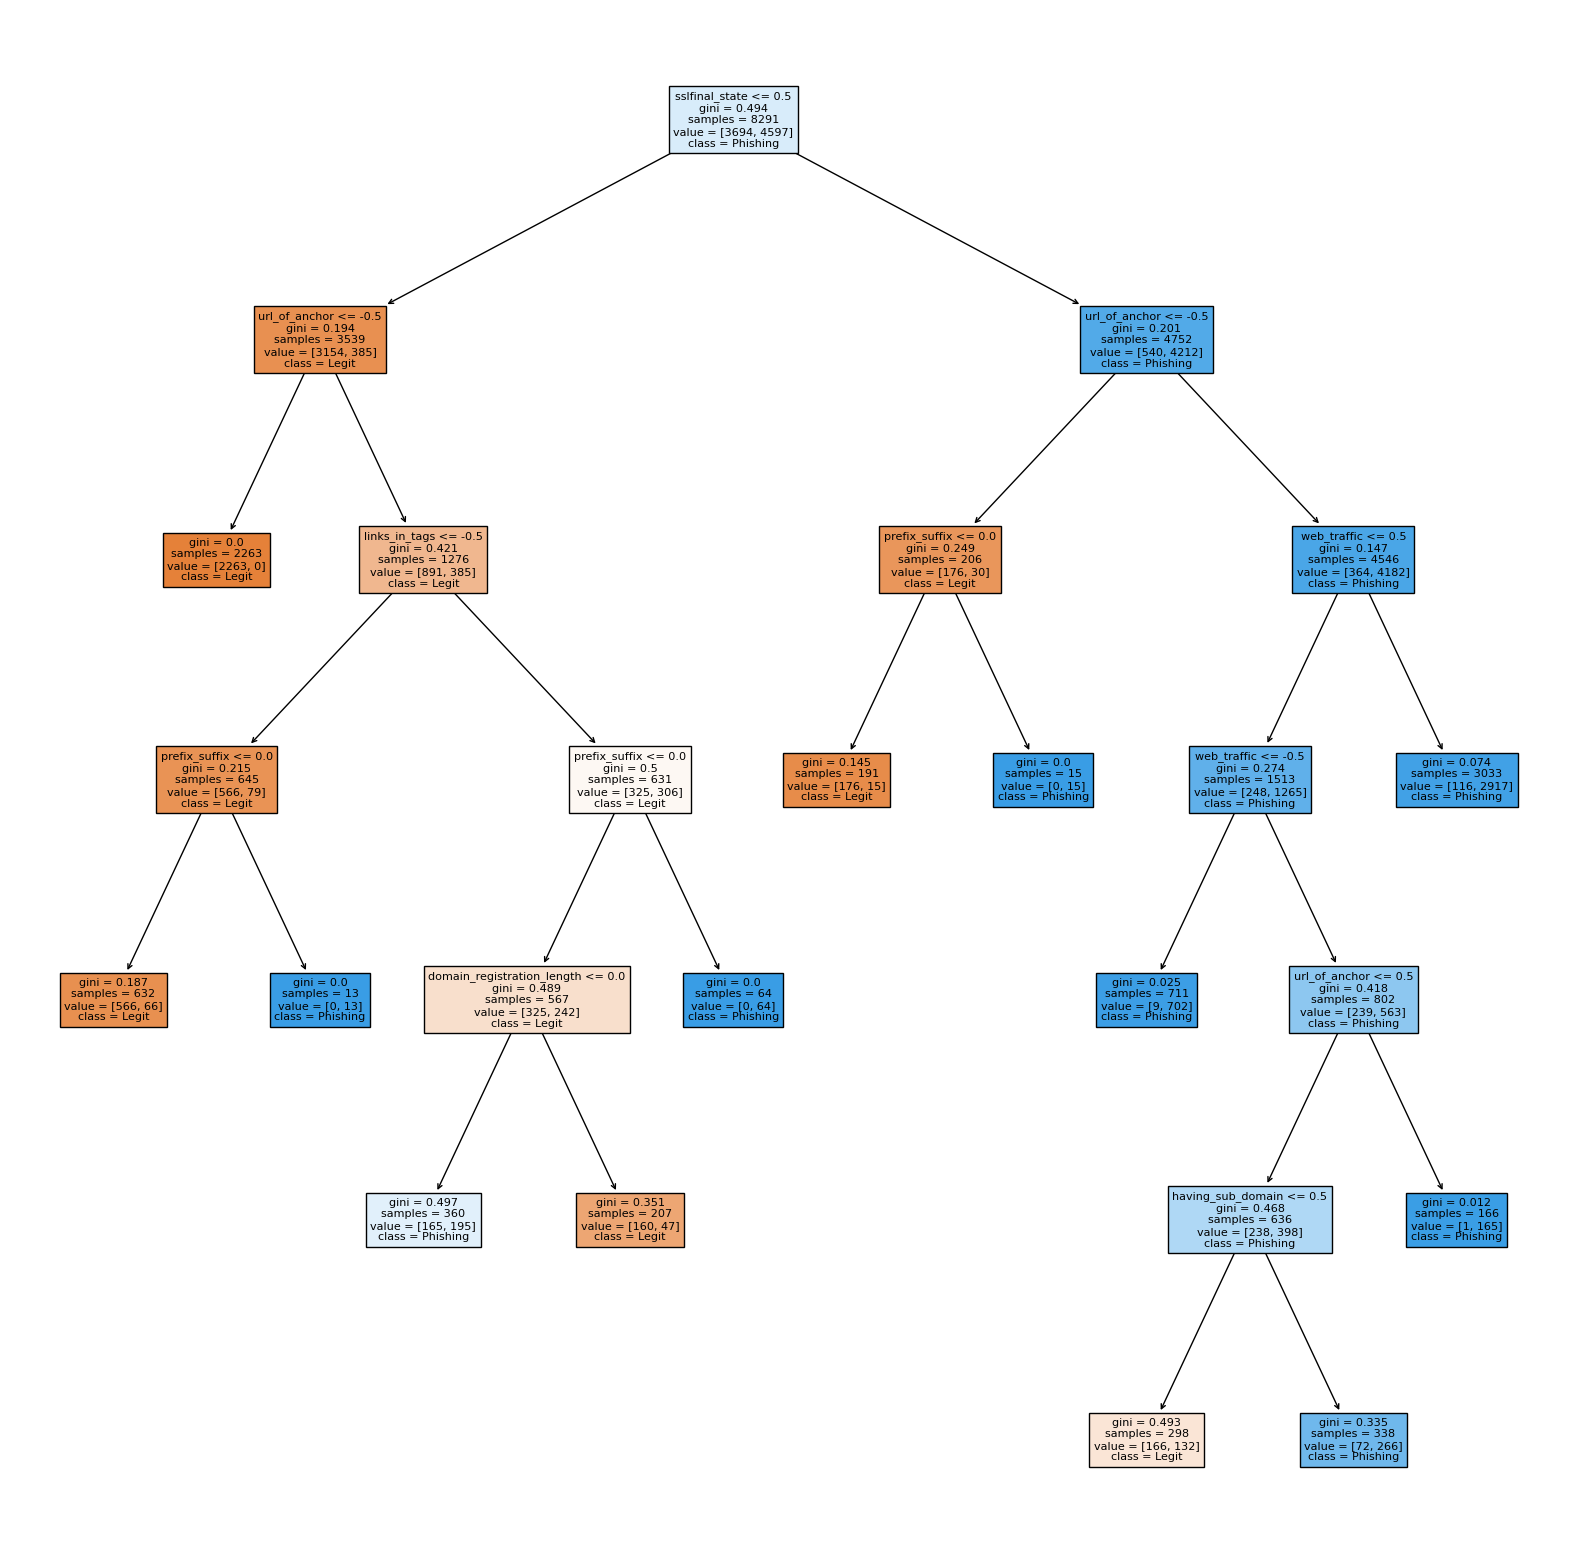

In [8]:
model_pruned = DecisionTreeClassifier(random_state=20, ccp_alpha=0.0022).fit(X_train, y_train)
model = DecisionTreeClassifier(random_state=20).fit(X_train, y_train)
fig = plt.figure(figsize = (20,20))
plot_tree(model_pruned, feature_names = X.keys().tolist(), filled=True, class_names = ['Legit', 'Phishing'])
plt.show()

In [9]:
from sklearn.metrics import classification_report, accuracy_score

y_pred = model_pruned.predict(X_test)
asd_pred = model.predict(X_test)
y_pred2 = model_pruned.predict(X_train)

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Training Accuracy:",accuracy_score(y_train, y_pred2))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Node Count:",model_pruned.get_n_leaves())

Test Accuracy: 0.9298118668596237
Training Accuracy: 0.9248582800627186
Classification Report:
               precision    recall  f1-score   support

          -1       0.93      0.91      0.92      1204
           1       0.93      0.94      0.94      1560

    accuracy                           0.93      2764
   macro avg       0.93      0.93      0.93      2764
weighted avg       0.93      0.93      0.93      2764

Node Count: 13


In [10]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model_pruned, X_test, y_test, cv=10)
scores2 = cross_val_score(model, X_test, y_test, cv=10)

print("Average CV accuracy for pruned model", scores.mean())
print("Average CV accuracy without pruning", scores2.mean())

Average CV accuracy for pruned model 0.9305446554700989
Average CV accuracy without pruning 0.9269083869617539


## Evaluation
### Decision tree vs Random forest
- Trained a random forest with 100 trees
- Tested different hyperparameters to find the most suitable ones
- Results
    - The random forest performed marginally better than the decision tree
    - Decision tree model is optimal for human interpretation

Random forest section

In [11]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, bootstrap=True, max_samples=0.7, max_features=0.6, random_state=123)
rf_model.fit(X_train, y_train.to_numpy().reshape(-1))

y_pred_rf = rf_model.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))
print(f'Confusion matrix:\n{confusion_matrix(y_test, y_pred)}')

Random Forest Accuracy: 0.9768451519536903
Random Forest Classification Report:
               precision    recall  f1-score   support

          -1       0.98      0.97      0.97      1204
           1       0.98      0.98      0.98      1560

    accuracy                           0.98      2764
   macro avg       0.98      0.98      0.98      2764
weighted avg       0.98      0.98      0.98      2764

Confusion matrix:
[[1098  106]
 [  88 1472]]


In [12]:
feature_importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)
print(feature_importances.sort_values(ascending=False).head(10))

sslfinal_state                0.478820
url_of_anchor                 0.219546
web_traffic                   0.041641
having_sub_domain             0.036263
links_in_tags                 0.035566
prefix_suffix                 0.028515
links_pointing_to_page        0.018069
age_of_domain                 0.014086
domain_registration_length    0.013304
request_url                   0.012540
dtype: float64


## Deployment
Integrate the model into a browser extension that warns users when entering suspicious sites. We would also like to test our model on real world phishing URL:s